## Learning Young's modulus (m) to displacement (u) map for Linear Elasticity problem (Implementation 1)

Data is located in `../data` directory, and key data of our interest is in `LinearElasticity_samples.npz` file. We would also need the mesh data in files with names `LinearElasticity_m_mesh` and `LinearElasticity_u_mesh` for plotting.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement1/neural_operator_prediction_comparison.png" width="800"> </p>

In [28]:
import sys
import os
import time

# os.environ['CUDA_VISIBLE_DEVICES']='-1'
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

import numpy as np
import scipy
import scipy.io as io

import dolfin as dl

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

In [29]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement1/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Data related methods

In [30]:
class DataProcessor:
    def __init__(self, batch_size, num_train = 1900, num_test = 100, \
                 num_inp_fn_points = 2601, num_out_fn_points = 2601):
        self.batch_size = batch_size
        self.num_train = num_train
        self.num_test = num_test
        self.num_inp_fn_points = num_inp_fn_points
        self.num_out_fn_points = num_out_fn_points
        self.num_Y_components = 2 # displacement field in 2D

        self.data, self.X_trunk, self.X_train, self.Y_train, \
            self.X_test, self.Y_test, self.X_train_mean, \
            self.X_train_std, self.Y_train_mean, self.Y_train_std, \
            self.tol = self.load_data()

        self.X_trunk_min = np.min(self.X_trunk, axis = 0)
        self.X_trunk_max = np.max(self.X_trunk, axis = 0)
    
    def load_data(self, tol = 1.0e-9):
        
        data = np.load(data_folder + 'LinearElasticity_samples.npz')

        # trunk input data ('xi' coordinates)
        X_trunk = data['u_mesh_nodes']
        
        # branch input data ('m' functions)
        X_train = data['m_samples'][:self.num_train,:]
        X_test = data['m_samples'][self.num_train:(self.num_train + self.num_test),:]

        X_train_mean = np.mean(np.reshape(X_train, (-1, self.num_inp_fn_points)), 0)
        X_train_mean = np.reshape(X_train_mean, (-1, 1, self.num_inp_fn_points))

        X_train_std = np.std(np.reshape(X_train, (-1, self.num_inp_fn_points)), 0)
        X_train_std = np.reshape(X_train_std, (-1, 1, self.num_inp_fn_points))

        X_train = np.reshape(X_train, (-1, 1, self.num_inp_fn_points))
        X_train = (X_train - X_train_mean)/(X_train_std + tol)

        X_test = np.reshape(X_test, (-1, 1, self.num_inp_fn_points))
        X_test = (X_test - X_train_mean)/(X_train_std + tol)

        # output data ('u' functions)
        Y_train = data['u_samples'][:self.num_train,:]
        Y_test = data['u_samples'][self.num_train:(self.num_train + self.num_test),:]

        if self.num_out_fn_points != Y_train.shape[1]:
            raise ValueError('num_out_fn_points does not match the number of output function points in the data')

        Y_train_mean = np.mean(Y_train, 0)
        Y_train_mean = np.reshape(Y_train_mean, (-1, self.num_out_fn_points, self.num_Y_components))
        
        Y_train_std = np.std(Y_train, 0)
        Y_train_std = np.reshape(Y_train_std, (-1, self.num_out_fn_points, self.num_Y_components))

        Y_train = (Y_train - Y_train_mean)/(Y_train_std + tol)
        Y_test = (Y_test - Y_train_mean)/(Y_train_std + tol)

        return data, X_trunk, X_train, Y_train, X_test, Y_test, X_train_mean, X_train_std, Y_train_mean, Y_train_std, tol
        
    def minibatch(self):

        batch_id = np.random.choice(self.X_train.shape[0], self.batch_size, replace=False)

        X_train = [self.X_train[i:i+1] for i in batch_id]
        X_train = np.concatenate(X_train, axis=0)
        Y_train = [self.Y_train[i:i+1] for i in batch_id]
        Y_train = np.concatenate(Y_train, axis=0)

        X_trunk_train = self.X_trunk
        X_trunk_min = self.X_trunk_min
        X_trunk_max = self.X_trunk_max

        return X_train, X_trunk_train, Y_train, X_trunk_min, X_trunk_max

    def testbatch(self, num_test):
        batch_id = np.arange(num_test)
        X_test = [self.X_test[i:i+1] for i in batch_id]
        X_test = np.concatenate(X_test, axis=0)
        Y_test = [self.Y_test[i:i+1] for i in batch_id]
        Y_test = np.concatenate(Y_test, axis=0)
        X_trunk_test = self.X_trunk

        return X_test, X_trunk_test, Y_test
    
    def encoder_Y(self, x):
        x = (x - self.Y_train_mean)/(self.Y_train_std + self.tol)
        return x
    
    def encoder_Y_1d(self, x):    
        x[:, :] = (x[:, :] - self.Y_train_mean[0,:,:])/(self.Y_train_std[0,:,:] + self.tol)
        return x

    def decoder_Y(self, x):
        x = x*(self.Y_train_std + self.tol) + self.Y_train_mean
        return x
    
    def decoder_Y_1d(self, x):
        # assume x is 1D array times num_Y_components
        x[:, :] = x[:,:]*(self.Y_train_std[0,:,:] + self.tol) + self.Y_train_mean[0,:,:]
        return x
    
    def encoder_X(self, x):
        x = (x - self.X_train_mean)/(self.X_train_std + self.tol)
        return x
    
    def encoder_X_1d(self, x):    
        x[:] = (x[:] - self.X_train_mean[0,:,0])/(self.X_train_std[0,:,0] + self.tol)
        return x
    
    def decoder_X(self, x):
        x = x*(self.X_train_std + self.tol) + self.X_train_mean
        return x
    
    def decoder_X_1d(self, x):
        # assume x is 1D array
        x[:] = x[:]*(self.X_train_std[0,:,0] + self.tol) + self.X_train_mean[0,:,0]
        return x

In [31]:
class SaveData:
    def __init__(self):
        pass

    def save(self, sess, X_trunk_pos, fnn_model, \
             W_T, b_T, W_B, b_B, \
             X_trunk_min, X_trunk_max, \
             X_ph, Y_ph, \
             data, num_test, \
             num_tr_outputs, num_Y_components, \
             results_dir):

        X_test, X_trunk_test, Y_test = data.testbatch(num_test)
        X_trunk = tf.tile(X_trunk_pos[None, :, :], [num_test, 1, 1])

        test_dict = {X_ph: X_test, Y_ph: Y_test}

        num_out_fn_points = X_trunk_test.shape[0]
        
        #Trunk net
        u_T = fnn_model.fnn_T(W_T, b_T, X_trunk, X_trunk_min, X_trunk_max)
        u_T = tf.tile(u_T, [1, 1, 2])

        # Branch net
        u_B = fnn_model.fnn_B(W_B, b_B, X_ph)
        u_B = tf.tile(u_B, [1, num_out_fn_points, 1])
        
        #inner product
        Y_pred = u_B*u_T
        Y_pred = tf.reshape(Y_pred, \
                            [-1, num_out_fn_points, num_tr_outputs, \
                                num_Y_components], \
                            name='F')
        Y_pred = tf.reduce_sum(Y_pred, axis=-2)

        # compute predictions
        Y_pred_ = sess.run(Y_pred, feed_dict=test_dict)

        # compute relative L2 error
        err = np.mean(np.square(Y_pred_ - Y_test))
        print('error (l2 squared): %.3f'%(err))

        err = np.reshape(err, (-1, 1))
        
        np.savetxt(results_dir+'/err.txt', err, fmt='%e')
        
        scipy.io.savemat(results_dir+'LinearElasticity_DeepONet.mat', 
                     mdict={'X_test': X_test,
                            'Y_test': Y_test, 
                            'Y_pred': Y_pred_})
        

## Define network methods

In [32]:
class FNN:
    def __init__(self):
        pass
    
    def hyper_initial(self, layers):
        L = len(layers)
        W = []
        b = []
        for l in range(1, L):
            in_dim = layers[l-1]
            out_dim = layers[l]
            std = np.sqrt(2./(in_dim + out_dim))
            weight = tf.Variable(tf.random_normal(shape=[in_dim, out_dim], stddev=std))
            bias = tf.Variable(tf.zeros(shape=[1, out_dim]))
            W.append(weight)
            b.append(bias)

        return W, b

    def fnn_T(self, W, b, X, Xmin, Xmax):
        A = 2.0*(X - Xmin)/(Xmax - Xmin) - 1.0
        L = len(W)
        for i in range(L-1):
            A = tf.nn.leaky_relu(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y
    
    def fnn_B(self, W, b, X):
        A = X
        L = len(W)
        for i in range(L-1):
            A = tf.nn.leaky_relu(tf.add(tf.matmul(A, W[i]), b[i]))
        Y = tf.add(tf.matmul(A, W[-1]), b[-1])
        
        return Y
    

## Load data

In [33]:
num_train = 1900
num_test = 100

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_br_outputs = 200 # 100 for u1 and 100 for u2
num_tr_outputs = 100 # number of outputs from the trunk network before they are multiplied
num_Y_components = 2 # displacement field in 2D

#branch net
layer_B = [num_inp_fn_points, 128, 128, num_br_outputs]
#trunk net
layer_T = [2, 128, 128, num_tr_outputs]

#batch_size
batch_size = 100
epochs = 1000
lr = 1.0e-3

data = DataProcessor(batch_size, num_train = num_train, num_test = num_test, num_inp_fn_points = num_inp_fn_points, num_out_fn_points = num_out_fn_points)

## Create model and train the network

In [34]:
X_train, X_trunk_train, Y_train, X_trunk_min, X_trunk_max = data.minibatch()
X_trunk_pos = tf.constant(X_trunk_train, dtype=tf.float32)
X_trunk_tf = tf.tile(X_trunk_pos[None, :, :], [batch_size, 1, 1]) #[bs, x_num, x_dim]

X_ph = tf.placeholder(shape=[None, 1, num_inp_fn_points], dtype=tf.float32) #[bs, f_dim]
Y_ph = tf.placeholder(shape=[None, num_out_fn_points, num_Y_components], dtype=tf.float32) #[bs, x_num, 1]

learning_rate = tf.placeholder(tf.float32, shape=[])

fnn_model = FNN()

# Branch net
W_B, b_B = fnn_model.hyper_initial(layer_B)
u_B = fnn_model.fnn_B(W_B, b_B, X_ph)
u_B = tf.tile(u_B, [1, num_out_fn_points, 1])   
print('u_B.shape:', u_B.shape)

# Trunk net
W_T, b_T = fnn_model.hyper_initial(layer_T)
u_T = fnn_model.fnn_T(W_T, b_T, X_trunk_tf, X_trunk_min, X_trunk_max)
u_T = tf.tile(u_T, [1, 1, 2])
print('u_T.shape:', u_T.shape)

#inner product
Y_pred = u_B*u_T
Y_pred = tf.reshape(Y_pred, [-1, num_out_fn_points, num_tr_outputs, num_Y_components], name='F')
Y_pred = tf.reduce_sum(Y_pred, axis=-2)
print('Y_pred.shape:', Y_pred.shape)

u_B.shape: (?, 2601, 200)
u_T.shape: (100, 2601, 200)
Y_pred.shape: (100, 2601, 2)


In [35]:
# loss function
loss = tf.reduce_mean(tf.square(Y_ph - Y_pred))
train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
saver = tf.train.Saver()
sess = tf.Session()  
sess.run(tf.global_variables_initializer())

# verify the error calculation
X_train, X_trunk_train, Y_train, _, _ = data.minibatch()
train_dict={X_ph: X_train, Y_ph: Y_train, learning_rate: lr}
loss_ = sess.run(loss, feed_dict=train_dict)

Y_train_ = sess.run(Y_pred, feed_dict={X_ph: X_train})
err = np.mean(np.square(Y_train_ - Y_train))

print('='*30)
print('Train Loss (l2 squared): {:.3e}, Train Loss (l2 squared): {:.3e}'.format(loss_, err))
print('='*30)

I0000 00:00:1731118414.248088  303943 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731118414.248429  303943 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731118414.248751  303943 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731118414.249059  303943 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Train Loss (l2 squared): 9.607e-01, Train Loss (l2 squared): 9.607e-01


In [36]:
# begin training
n = 0
start_time = time.perf_counter()

train_loss = np.zeros((epochs+1, 1))
test_loss = np.zeros((epochs+1, 1))    

loss_print_freq = 100

while n <= epochs:

    if n < 1000:
        lr = 0.001
    elif n < 5000:
        lr = 0.0005
    else:
        lr = 0.0001
            
    start_time = time.perf_counter()

    # network training
    X_train, X_trunk_train, Y_train, _, _ = data.minibatch()
    train_dict={X_ph: X_train, Y_ph: Y_train, learning_rate: lr}
    loss_, _ = sess.run([loss, train], feed_dict=train_dict)
    
    # network testing
    X_test, X_trunk_test, Y_test = data.testbatch(batch_size)
    Y_test_ = sess.run(Y_pred, feed_dict={X_ph: X_test})
    # Y_test = data.decoder_Y(Y_test)
    # Y_test_ = data.decoder_Y(Y_test_)
    
    # testing error
    err = np.mean(np.square(Y_test_ - Y_test))
    
    end_time = time.perf_counter()

    epoch_time = end_time - start_time

    if n % loss_print_freq == 0:
        print('='*30)
        print('Epoch: {:5d}, Train Loss (l2 squared): {:.3e}, Test Loss (l2 squared): {:.3e}, Time (sec): {:.3f}'.format(n, loss_, err, epoch_time))
        print('='*30)

    train_loss[n,0] = loss_
    test_loss[n,0] = err
    n += 1

Epoch:     0, Train Loss (l2 squared): 9.147e-01, Test Loss (l2 squared): 1.190e+00, Time (sec): 0.392
Epoch:   100, Train Loss (l2 squared): 5.347e-01, Test Loss (l2 squared): 2.950e-01, Time (sec): 0.059
Epoch:   200, Train Loss (l2 squared): 3.759e-01, Test Loss (l2 squared): 2.635e-01, Time (sec): 0.059
Epoch:   300, Train Loss (l2 squared): 1.929e-01, Test Loss (l2 squared): 2.625e-01, Time (sec): 0.059
Epoch:   400, Train Loss (l2 squared): 2.014e-01, Test Loss (l2 squared): 2.216e-01, Time (sec): 0.061
Epoch:   500, Train Loss (l2 squared): 2.470e-01, Test Loss (l2 squared): 2.070e-01, Time (sec): 0.060
Epoch:   600, Train Loss (l2 squared): 2.382e-01, Test Loss (l2 squared): 2.218e-01, Time (sec): 0.058
Epoch:   700, Train Loss (l2 squared): 2.043e-01, Test Loss (l2 squared): 2.247e-01, Time (sec): 0.059
Epoch:   800, Train Loss (l2 squared): 2.054e-01, Test Loss (l2 squared): 2.351e-01, Time (sec): 0.057
Epoch:   900, Train Loss (l2 squared): 1.618e-01, Test Loss (l2 squared):

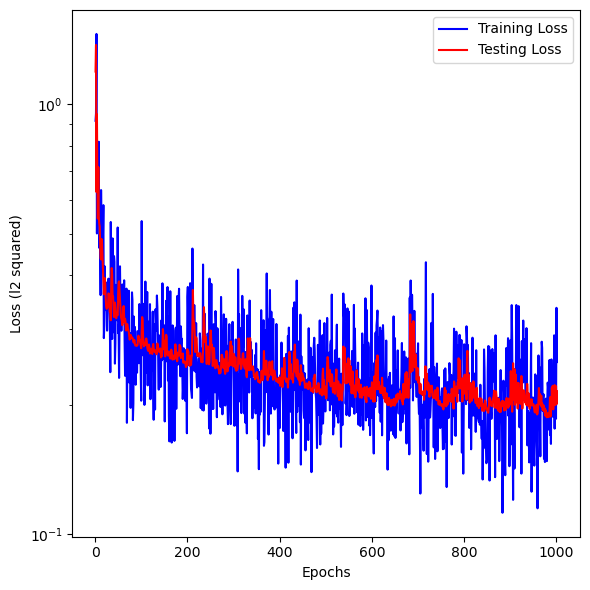

In [37]:
## Plotting the loss history
num_epoch = train_loss.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, train_loss[:,0], color='blue', label='Training Loss')
ax.plot(x, test_loss[:,0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

In [38]:
save_models_to = results_dir +"model/"
if not os.path.exists(save_models_to):
    os.makedirs(save_models_to)      

saver.save(sess, save_models_to+'Model')

np.savetxt(results_dir+'/train_loss.txt', train_loss)
np.savetxt(results_dir+'/test_loss.txt', test_loss)

data_save = SaveData()
data_save.save(sess, X_trunk_pos, fnn_model, \
             W_T, b_T, W_B, b_B, \
             X_trunk_min, X_trunk_max, \
             X_ph, Y_ph, \
             data, num_test, \
             num_tr_outputs, num_Y_components, \
             results_dir)

error (l2 squared): 0.215


## Test and plot the output of network

In [39]:
X_test, X_trunk_test, Y_test = data.testbatch(batch_size)
Y_test_pred = sess.run(Y_pred, feed_dict={X_ph: X_test})

error = np.linalg.norm(Y_test_pred - Y_test, 2, axis=1)/np.linalg.norm(Y_test, 2, axis=1)

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 2601, 2), test_pred shape: (100, 2601, 2)
Num tests:   100, Mean Loss (rel l2): 4.604e-01, Std Loss (rel l2): 2.769e-01


In [40]:
def get_FE_space(mesh_file = data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector = False):
    mesh = dl.Mesh()
    with dl.XDMFFile(mesh_file) as infile:
        infile.read(mesh)
    if is_vector:
        V = dl.VectorFunctionSpace(mesh, "Lagrange", 1)
    else:
        V = dl.FunctionSpace(mesh, "Lagrange", 1)
    return V

In [41]:
Vu = get_FE_space(data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector=True)
i_pred = Y_test_pred[0, :, :].flatten()
u_fn = dl.Function(Vu)
u_vec = u_fn.vector().get_local()
print('u_vec shape: {}, i_pred shape: {}'.format(u_vec.shape, i_pred.shape))

u_vec shape: (5202,), i_pred shape: (5202,)


i_plot =    75, error (rel l2): 1.300e-02
i_plot =    54, error (rel l2): 6.301e-02
i_plot =    74, error (rel l2): 5.459e-02
i_plot =    56, error (rel l2): 6.352e-03
i_plot =    43, error (rel l2): 9.582e-03
i_plot =    51, error (rel l2): 8.020e-03
i_plot =    82, error (rel l2): 9.202e-03
i_plot =    89, error (rel l2): 1.059e-02
i_plot =    50, error (rel l2): 1.020e-02
i_plot =    10, error (rel l2): 1.051e-02
i_plot =    11, error (rel l2): 6.134e-03
i_plot =    76, error (rel l2): 1.461e-02
i_plot =     7, error (rel l2): 3.620e-02
i_plot =    18, error (rel l2): 1.470e-02
i_plot =    21, error (rel l2): 1.574e-02
i_plot =     3, error (rel l2): 1.414e-02


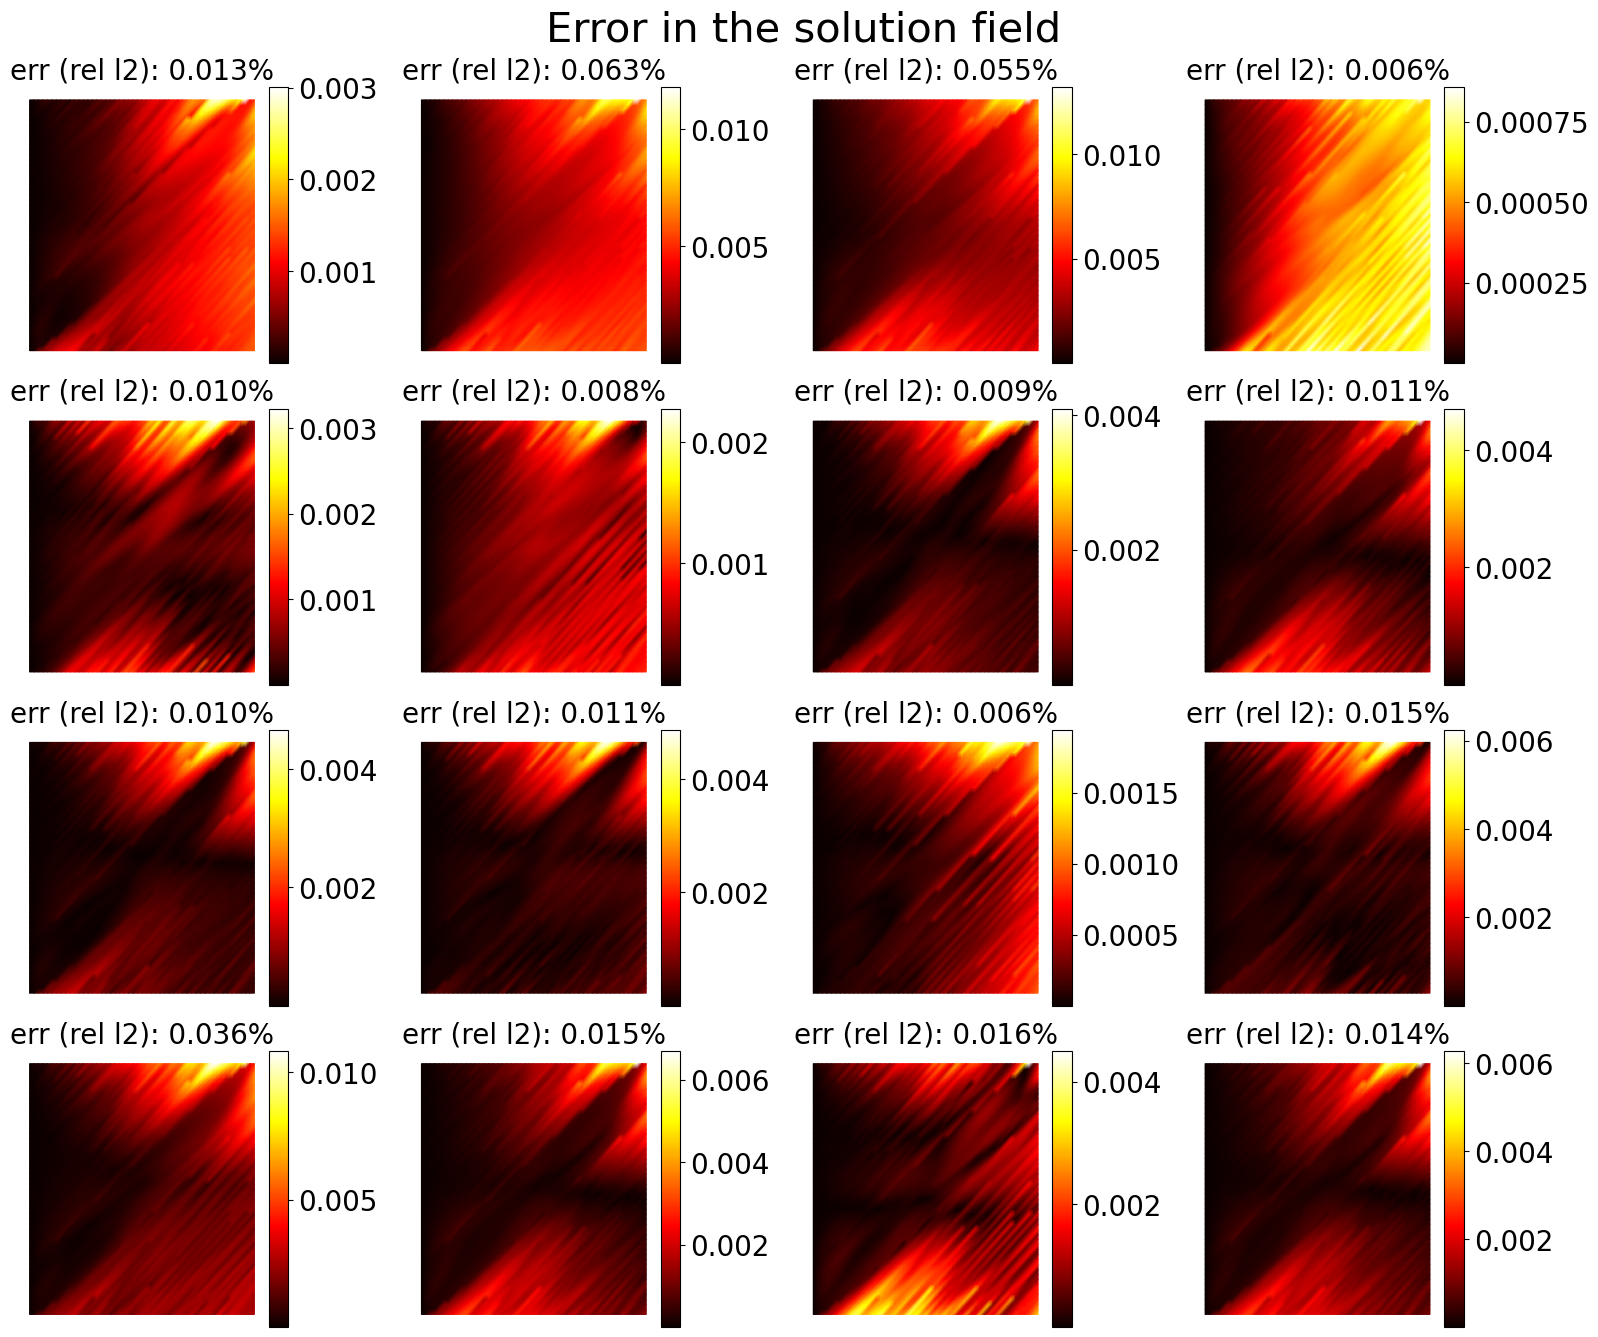

In [42]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + 'LinearElasticity_m_mesh.xdmf')

Y_spatial_points = data.X_trunk

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows*cols, replace=False)

for i in range(rows):
    for j in range(cols):
        i_plot = i_choices[i*cols + j]

        i_pred = Y_test_pred[i_plot, :, :]
        i_truth = Y_test[i_plot, :, :]
        if decode:
            i_pred = data.decoder_Y_1d(i_pred)
            i_truth = data.decoder_Y_1d(i_truth)
            
        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = Y_spatial_points

        cbar = field_plot_fenics(axs[i,j], i_diff.flatten(), \
                                     Vu, \
                                     cmap = 'hot', \
                                     add_displacement_to_nodes = False, \
                                     is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
        axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()


i_plot =    75, error (rel l2): 1.203e-02
i_plot =    54, error (rel l2): 6.470e-02
i_plot =    74, error (rel l2): 5.145e-02
i_plot =    56, error (rel l2): 6.928e-03


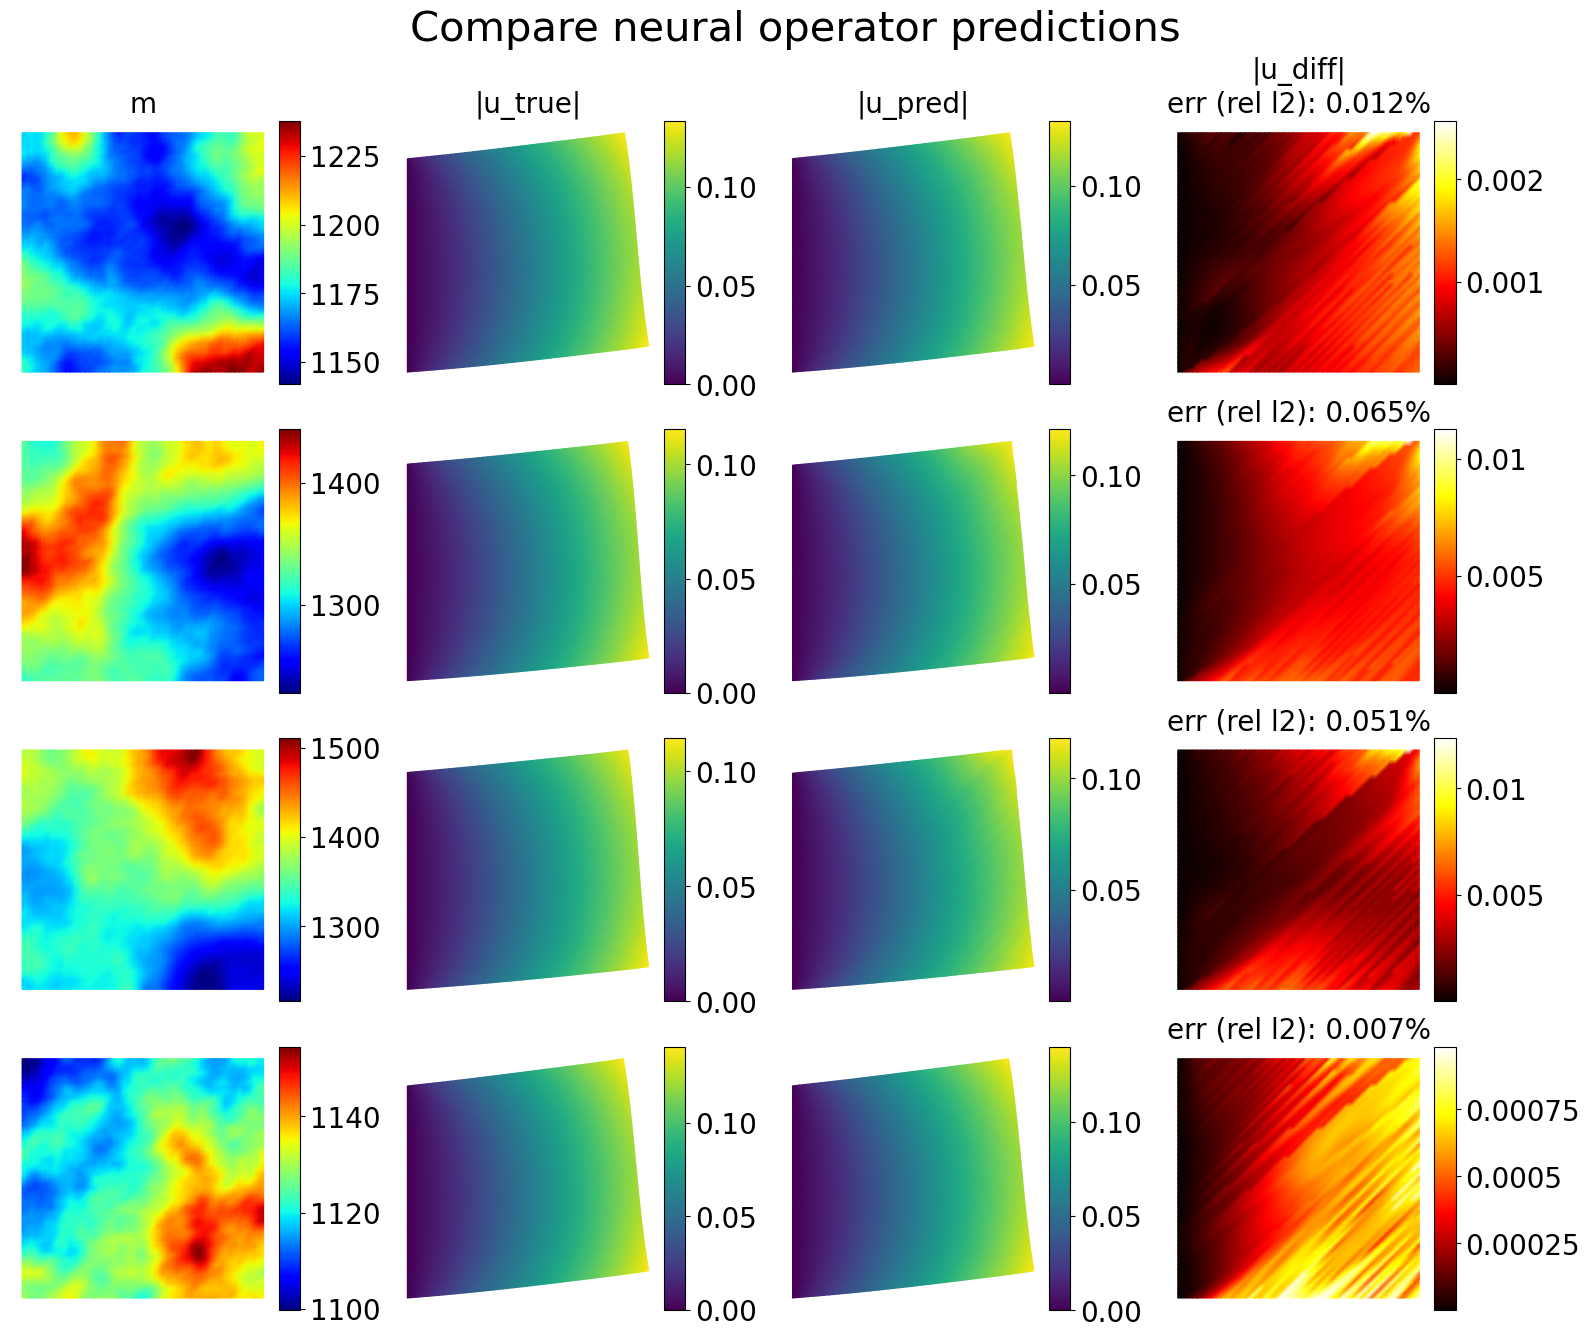

In [16]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + 'LinearElasticity_m_mesh.xdmf')

# row: m, u_true, u_pred, u_diff
u_tags = ['m', '|u_true|', '|u_pred|', '|u_diff|']
cmaps = ['jet', 'viridis', 'viridis', 'hot']
Vvec = [Vm, Vu, Vu, Vu]
Y_spatial_points = data.X_trunk # for this problem, nodes are same for m and u functions
X_spatial_points = Y_spatial_points

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot, :, :]
    i_truth = Y_test[i_plot, :, :]
    i_m_test = X_test[i_plot, 0, :]
    if decode:
        i_pred = data.decoder_Y_1d(i_pred)
        i_truth = data.decoder_Y_1d(i_truth)
        i_m_test = data.decoder_X_1d(i_m_test)
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        nodes = Y_spatial_points if j > 0 else X_spatial_points
        
        if j == 0:
            cbar = field_plot_fenics(axs[i,j], uvec[j], Vvec[j], cmap = cmaps
            [j])
        elif j == cols - 1:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = False,\
                                     is_displacement = True)
        else:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = True,\
                                     is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()


# Scratch

In [17]:
data = np.load(data_folder + 'LinearElasticity_samples.npz')

num_Y_components = 2 # displacement field in 2D
num_out_fn_points = 2601
num_train, num_test = 1900, 100
tol = 1.0e-9

# output data ('u' functions)
Y_train = data['u_samples'][:num_train,:]
Y_test = data['u_samples'][num_train:(num_train + num_test),:]

print('Y_train shape: {}, Y_test shape: {}'.format(Y_train.shape, Y_test.shape))

if num_out_fn_points != Y_train.shape[1]:
    raise ValueError('num_out_fn_points does not match the number of output function points in the data')

Y_train_mean = np.mean(Y_train, 0)
print('Y_train_mean shape: {}'.format(Y_train_mean.shape))
Y_train_mean = np.reshape(Y_train_mean, (-1, num_out_fn_points, num_Y_components))
print('Y_train_mean shape: {}'.format(Y_train_mean.shape))

Y_train_std = np.std(Y_train, 0)
Y_train_std = np.reshape(Y_train_std, (-1, num_out_fn_points, num_Y_components))

Y_train = (Y_train - Y_train_mean)/(Y_train_std + tol)
Y_test = (Y_test - Y_train_mean)/(Y_train_std + tol)

Y_train shape: (1900, 2601, 2), Y_test shape: (100, 2601, 2)
Y_train_mean shape: (2601, 2)
Y_train_mean shape: (1, 2601, 2)


In [18]:
a = np.arange(2 * 4, dtype=np.int8)
b = np.reshape(a, (2, 4))

for i in range(2):
    print(b[i,:])

[0 1 2 3]
[4 5 6 7]


In [19]:
a = 1 + np.arange(4*2, dtype=np.int8)
a[:4] = a[:4]*10
b = np.reshape(a, (4, 2), order='F')
print(a)

print('\n\n\n')
for j in range(2):
    print('j = ', j)
    print(b[:,j])

[10 20 30 40  5  6  7  8]




j =  0
[10 20 30 40]
j =  1
[5 6 7 8]


In [20]:
a = np.random.rand(2, 10, 20)
b = a.reshape(-1, 10, 10, 2, order='F')

print('a shape: {}, b shape: {}'.format(a.shape, b.shape))

# verify
for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        aa = a[i,j,:]
        bb = b[i,j,:,:]
        bb1 = bb[:,0]
        bb2 = bb[:,1]
        bb_combined = np.concatenate((bb1, bb2))
        print('aa shape: {}, bb shape: {}, bb_combined shape: {}'.format(aa.shape, bb.shape, bb_combined.shape))
        assert np.allclose(aa, bb_combined)

a shape: (2, 10, 20), b shape: (2, 10, 10, 2)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_combined shape: (20,)
aa shape: (20,), bb shape: (10, 2), bb_

In [21]:
a = np.random.rand(10, 1, 2)
b = a.reshape(10, 2, order='F')
a[1], b[1]

(array([[0.13795035, 0.4095522 ]]), array([0.13795035, 0.4095522 ]))

In [22]:
a = np.random.rand(10, 5, 2)
b = np.random.rand(10, 5, 2)

c = np.linalg.norm(np.linalg.norm(a - b, 2, axis=2), 2, axis=1)
d = np.linalg.norm(np.linalg.norm(a, 2, axis=2), 2, axis=1)

print('c shape: {}, d shape: {}'.format(c.shape, d.shape))

err = np.mean(c, axis=0)
print('err: ', err)

err_red = np.mean(np.square(a - b)/np.square(b))
print('err_red: ', err_red)

a[1,1,:] = a[1,1,:] * 5
ctf = tf.reduce_mean(tf.square(a))
print('ctf: ', ctf)





c shape: (10,), d shape: (10,)
err:  1.4182705976152459
err_red:  57.2005092441804
ctf:  Tensor("Mean_1:0", shape=(), dtype=float64)


In [23]:
np.square(a - b)

array([[[3.16405168e-02, 7.61951909e-02],
        [2.16296028e-01, 2.25317781e-01],
        [2.71014883e-01, 1.51229554e-01],
        [3.66075970e-01, 2.11090201e-04],
        [2.38116948e-01, 5.80817260e-02]],

       [[2.33518863e-01, 5.19295208e-02],
        [1.29033524e+01, 2.15883250e+01],
        [7.38530670e-03, 2.92884778e-01],
        [5.15785588e-01, 3.99798429e-01],
        [3.88815446e-02, 5.22610956e-01]],

       [[1.30543908e-01, 1.98597693e-01],
        [1.33221722e-01, 2.04633305e-01],
        [3.49822215e-02, 5.72574444e-01],
        [1.67348675e-02, 4.25946179e-01],
        [2.80956508e-01, 8.08672894e-02]],

       [[3.18075535e-01, 4.02454662e-01],
        [6.56699244e-01, 2.91480375e-02],
        [1.00794930e-02, 6.47924843e-05],
        [2.03908430e-01, 1.38936791e-01],
        [5.43095593e-03, 2.70240103e-03]],

       [[4.57452830e-01, 2.88330086e-02],
        [2.09752535e-02, 3.63731155e-01],
        [1.28871382e-01, 6.84738003e-04],
        [8.69159803e-02, 5

In [24]:
a = np.random.rand(2, 2, 2)
print('a.shape: ', a.shape)

for i in range(a.shape[0]):
    for j in range(a.shape[1]):
        print(a[i,j,:])

b = np.tile(a, [1, 1, 2])
print('\n\nb.shape: ', b.shape)

for i in range(b.shape[0]):
    for j in range(b.shape[1]):
        print(b[i,j,:])

c = np.zeros((2, 2, 4))
c[:, :, :2] = a
c[:, :, 2:] = a

print('\n\nc.shape: ', c.shape)

for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        print(c[i,j,:])

d = b - c
print('err: ', np.linalg.norm(d))

a.shape:  (2, 2, 2)
[0.36304886 0.59700781]
[0.43846388 0.06504823]
[0.76367076 0.67568575]
[0.67933018 0.23669816]


b.shape:  (2, 2, 4)
[0.36304886 0.59700781 0.36304886 0.59700781]
[0.43846388 0.06504823 0.43846388 0.06504823]
[0.76367076 0.67568575 0.76367076 0.67568575]
[0.67933018 0.23669816 0.67933018 0.23669816]


c.shape:  (2, 2, 4)
[0.36304886 0.59700781 0.36304886 0.59700781]
[0.43846388 0.06504823 0.43846388 0.06504823]
[0.76367076 0.67568575 0.76367076 0.67568575]
[0.67933018 0.23669816 0.67933018 0.23669816]
err:  0.0


In [25]:
a = np.random.rand(4, 2)
for i in range(a.shape[0]):
    print(a[i,:])

print('\n\n')
b = np.reshape(a, 4*2)
print(b[:])

print('\n\n')
c = a.flatten()
print(c[:])


[0.68107443 0.88547507]
[0.36086643 0.30587625]
[0.32739114 0.39882233]
[0.47090201 0.78552028]



[0.68107443 0.88547507 0.36086643 0.30587625 0.32739114 0.39882233
 0.47090201 0.78552028]



[0.68107443 0.88547507 0.36086643 0.30587625 0.32739114 0.39882233
 0.47090201 0.78552028]
